# Install this (important)

In [3]:
# Install the latest version of author's repo neural ode implementation
!git clone https://github.com/rtqichen/torchdiffeq.git
!cd torchdiffeq && pip install -e .
!ls torchdiffeq/torchdiffeq

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 1138, done.
remote: Counting objects: 100% (434/434), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 1138 (delta 256), reused 400 (delta 240), pack-reused 704
Receiving objects: 100% (1138/1138), 8.29 MiB | 19.88 MiB/s, done.
Resolving deltas: 100% (682/682), done.
Obtaining file:///content/torchdiffeq
  Running setup.py develop for torchdiffeq
_impl  __init__.py


In [4]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 21.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=6ae8b41fa9d58fcfa8f06229453cbab263f482aa047c891093b1cca18471f5c2
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# Data Collection and Clustering Algorithms

## Rough of Data Collection

1. Get Open and Close Price of asset (o, c) for each trading day.
2. Transform it into sequences.
    - $d_{i} : {o_{1}c_{1} ... o_{5}c_{5}}$
    - where $d_{i}$ is a sequence of o and c for the week `i`.
3. Transform $d_{i}$ to sequences of lag * len($d_{i}$) length.
4. Normalize these sequences to a range (0, 1).
5. Clustering algorithm. 

In [ ]:
# 1. Get Open and Close Price of asset (o, c) for each trading day.
# libraries
from pandas_datareader import data as pdr
import yfinance as yf
import os

print(f"Get Open and Close Price of Assets")
def download_raw_stock_data(filepath, tickers, start, end, period = '1d'):
    """
    Download Stock tickers
    :Parameters:
        filepath: str
            path to store the raw data
        tickers : str, list
            List of tickers to download
        period: str
            the frequency at which to gather the data; common options would include ‘1d’ (daily), ‘1mo’ (monthly), ‘1y’ (yearly)
        start: str
            the date to start gathering the data. For example ‘2010–1–1’
        end: str
            the date to end gathering the data. For example ‘2020–1–25’
    
    """
    #define the ticker symbol
    tickerSymbol = tickers

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period=period, start=start, end=end)
    tickerDf.to_csv(filepath)

dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}

path = f"raw-stock-data/data-2000-2021"
if not os.path.exists(path):
    # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
    # Create a new directory
    os.makedirs(path)
    print(f"{path} directory is created")
period = '1d'
start='2000-1-1'
end='2021-8-31'
for tickerName, ticker in dict_tickers.items():
    tickerName = tickerName
    ticker = ticker
    filepath = f"{path}/{tickerName}.csv"
    download_raw_stock_data(filepath, ticker, start, end, period)


print('\n')

print(f"The size of each asset")
import pandas as pd
for tickerName in dict_tickers.keys():
    df = pd.read_csv(f"{path}/{tickerName}.csv")
    print(f"{tickerName} size: {len(df)}")

Get Open and Close Price of Assets
raw-stock-data/data-2000-2021 directory is created


In [ ]:
len(dict_tickers.keys())

### 2. Transform it into sequences.
    - $d_{i} : {o_{1}c_{1} ... o_{5}c_{5}}$
    - where $d_{i}$ is a sequence of o and c for the week `i`.
3. Transform $d_{i}$ to sequences of lag * len($d_{i}$) length.


In [ ]:
# 2. Get weekly data.
# 3. Transform $d_{i}$ to sequences of lag * len($d_{i}$) length.

def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def split_data(perc_train, perc_valid, lag, data_orig, data_m1, n_features_orig, n_features_median):
    values = data_m1
    
    sizeOfReframed = len(data_m1)
    len_train = int(perc_train*sizeOfReframed) # int(sizeOfReframed - len_test) # - len_valid)
    train_data_orig = data_orig[:len_train, :]
    # valid = values[len_train:len_valid+len_train, :]
    test_data_orig = data_orig[len_train:, :]  # [len_valid+len_train:, :]
    # n_features = n_features
    
    train_data_ml = values[:len_train, :]
    test_data_ml = values[len_train:, :] 
    # split into input and outputs
    n_obs = lag * n_features_orig
    n_obs_median = (lag+forecast) * n_features_median
    train_X, train_y = train_data_orig[:, :n_obs], train_data_ml[:, :n_obs_median]
    test_X, test_y = test_data_orig[:, :n_obs], test_data_ml[:, :n_obs_median]
    # valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
    print(train_X.shape, len(train_X), train_y.shape)
    
    # reshape input to be 3D [samples, features, lag]
    train_X = train_X.reshape((train_X.shape[0], n_features_orig, lag))
    test_X = test_X.reshape((test_X.shape[0], n_features_orig, lag))
    # valid_X = valid_X.reshape((valid_X.shape[0], lag, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)  # , valid_X.shape, valid_y.shape)
    
    # Get the reconstruction train_y, test_y and extrapolated train_y, test_y
    train_y_recon, train_y_extrapol = train_y[:, :lag], train_y[:, lag:]
    test_y_recon, test_y_extrapol = test_y[:, :lag], test_y[:, lag:]
    dataload = {
        'train_data_orig': train_data_orig,
        'test_data_orig': test_data_orig,
        'train_data_ml': train_data_ml,
        'test_data_ml': test_data_ml,
        # 'valid': valid,
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'n_features_orig': n_features_orig,
        'n_features_median': n_features_median,
        'n_obs': n_obs,
        'n_obs_median': n_obs_median,
        # 'valid_X': valid_X,
        # 'valid_y': valid_y,
        'train_y_recon': train_y_recon,
        'train_y_extrapol': train_y_extrapol,
        'test_y_recon': test_y_recon,
        'test_y_extrapol': test_y_extrapol
    }
    
    return dataload

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)
    

In [ ]:
from pandas import concat
import numpy as np
week_sequence = {}
median_data_dict = {}
lag = 5
for tickerName in dict_tickers.keys():
    filepath = f"{path}/{tickerName}.csv"
    # Get the data in the required format
    data = stockDataTransformer(filepath)
    # # Total Data Size
    data_size = data.shape[0]
    print(f"{tickerName} data.shape {data.shape}")
    data_orig = series_to_supervised(data, lag).values
    print(f'{tickerName} Data Original after series to supervised on data {data_orig.shape}')
    week_sequence[tickerName] = data_orig

    median_data = get_median(data)
    print(f'{tickerName} Median data')
    # Median data for each week
    print(f"{tickerName} median_data.shape {median_data.shape}")
    # print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
    print('\n')

    # Convert median_data to (n_samples, 5) matrix
    data_m1 = series_to_supervised(median_data, lag).values
    median_data_dict[tickerName] = data_m1
    print(f'{tickerName} Median data after series to supervised')
    print(f"{tickerName} data_m1.shape {data_m1.shape}")
    # print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]))
    print('\n')





In [ ]:
import numpy as np
data = week_sequence['Apple']
# 4. Bundle all sequences together
for tickerName in week_sequence.keys():
    if tickerName != 'Apple':
        data1 = week_sequence[tickerName]
        data = np.concatenate((data, data1))
        print(f"data.shape {data.shape}")


In [ ]:
data_df = pd.DataFrame(data)
data_df.to_csv(f"all_assets_sequences.csv")

In [ ]:
data.shape

In [ ]:
# import numpy as np
# a1 = np.array([[1, 2, 3], [4, 5, 6]])
# a2 = np.array([[7, 8, 9], [10, 11, 12], [13, 14, 15]])
# a3 = np.array([[7, 8, 9], [10, 11, 12], [13, 14, 15]])
# np.concatenate((a1, a2, a3))

In [ ]:
data_df.head()

In [ ]:
data_df.describe()

### 4. Normalize these sequences to a range (0, 1).


In [ ]:
# 4. Normalize these sequences to a range (0, 1).
from sklearn import preprocessing 
# https://www.journaldev.com/45109/normalize-data-in-python
# Normalizes the sample
data_normalized = preprocessing.normalize(data_df)
data_normalized_df = pd.DataFrame(data_normalized)
data_normalized_df.to_csv(f"all_assets_sequences_lag{lag+1}_normalized.csv")

### 5. Clustering algorithm. 


#### k-means clustering

In [ ]:
# 5. Clustering algorithm. 
# K Means

# K-Means Clustering

# One of the most commonly used methods of clustering is K-means Clustering 
# K Means allows us to define the required number of clusters
# Now we first start by taking an arbitrary number of k. Let’s say we take k=3 
# Now to form three groups from the set of data
# Algorithm chooses three random points as the centroid 
# It also computes Euclidean distances from the centroid to all other data points
# The algorithm after measuring the distances of all the data points 
# from the centroid associates each data point with a centroid based on its proximity

# Silhouette Score
# Clusters are well apart from each other as the silhouette score is closer to 1
# Silhouette Coefficient score is a metric used to calculate the goodness of a clustering technique 
# Its value ranges from -1 to 1.
# 1: Means clusters are well apart from each other and clearly distinguished.
# 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
# -1: Means clusters are assigned in the wrong way.

# Deciding Value of K
# The most crucial aspect of K-Means clustering is deciding the value of K
# We do this by performing Elbow Analysis 

# Library
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [ ]:

wcss=[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300,
                    n_init = 10, random_state = 0)
    kmeans.fit(data_normalized)
    print(f"Inertia for clusters = {i}: {kmeans.inertia_}")
    wcss.append(kmeans.inertia_)

print('Within Cluster Sum of Square (WCSS) for 10 Clusters')

# Inference : 
# Cluster 1 means only one cluster, inshort variance of the dataset
# Variance in Cluster 1 = 1515
# Cluster 2 means two cluster i.e, Variance in Cluster 2 = 104
# Same way for Variance in Cluster 3 = 79
# Vairance in Cluster is also knows as Within Cluster Sum of Square (WCSS)
# Normally as we increase number of clusters, within Sum of Square will decrease 

In [ ]:
# We now plot the WCSS obtained 

# WCSS or within-cluster sum of squares is a measure of 
# how internally coherent the clusters are K-Means tries to minimize this criterion

plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

# Inference : 
# In the elbow graph, we look for the points where the drop falls and the line smoothens out
# In the above graph, this happens for k=2. 
# Another way of understanding this is that we note the point at which the WCSS is less 
# and try to find the number of clusters for our dataset. 
# We see that at the number of clusters = 2, WCSS is less than 100, which is good for us. 
# So we take k =2.
# We will check Silhouette Coefficient also for 2 and 3 Clusters respectively

In [ ]:
# Running K-Means Model

# We now run K-Means clustering for obtaining a 2 cluster solution.
cluster_Kmeans = KMeans(n_clusters=3)
model_kmeans = cluster_Kmeans.fit(data_normalized)
pred_kmeans = model_kmeans.labels_
# print(pred_kmeans)

# Frequency count of the Output clusters
unique, counts = np.unique(pred_kmeans, return_counts=True)
dict(zip(unique, counts))

In [ ]:
# Frequency count of the Output clusters
unique, counts = np.unique(pred_kmeans, return_counts=True)
print('K Means Output Cluster Frequency')
print(dict(zip(unique, counts)))
# Silhouette Score
print('Silhouette Score for 8 Clusters')
print(silhouette_score(data_normalized,pred_kmeans))
print("\n")

# In the above output we got value labels: ‘0’, ‘1’

# Inference :   
# Silhouette Score = 0.91 which is great (should be tend to 1)

In [ ]:
# If we take 4 Cluster to Check Silhouetter Score
cluster_Kmeans = KMeans(n_clusters=3)
model_kmeans = cluster_Kmeans.fit(data_normalized)
labels_1 = model_kmeans.labels_
print("Silhouette Score for 3 Cluster")
print(silhouette_score(data_normalized,labels_1))

# Inference : 
# As we can observe Score is 0.29 (decrease so reject 3 Cluster)
# Optimal number of cluster=2 as its silhouette score is greater than that of 3 clusters

#### Hierarchial Clustering

In [ ]:
# Hierarchical Clustering 

# Agglomerative Clustering which is a method of clustering 
# which builds a hierarchy of clusters by merging together small clusters

# Silhouette Score
# Clusters are well apart from each other as the silhouette score is closer to 1
# Silhouette Coefficient score is a metric used to calculate the goodness of a clustering technique 
# Its value ranges from -1 to 1.
# 1: Means clusters are well apart from each other and clearly distinguished.
# 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
# -1: Means clusters are assigned in the wrong way.

# Importing Libraries

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


In [ ]:
# Plotting of Dendrogram

# We make use of dendrogram to decide the number of clusters required for our dataset
# A dendrogram is a tree diagram which illustrates the arrangement of clusters.
import scipy.cluster.hierarchy as sch
import os
# We finally plot a Dendrogram 
# which helps us in deciding what the threshold values should be for the clustering algorithm
# Basically, we decide the number of clusters by using this dendrogram.
path = f"plots-similarity"
if not os.path.exists(path):
    # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
    # Create a new directory
    os.makedirs(path)
    print(f"{path} directory is created")
Z = sch.linkage(data_normalized, method = 'median')
plt.figure(figsize=(20,7))
den = sch.dendrogram(Z)
plt.title('Dendrogram for the clustering of the data')
plt.xlabel('Type')
plt.ylabel('Euclidean distance in the space with other variables')
plt.savefig(f"{path}/Dendrogram for the clustering of the data (median).pdf", dpi = 150)
plt.show()

In [ ]:
# Single Linkage - Nearest Point

Z = sch.linkage(data_normalized, method = 'single')
plt.figure(figsize=(20,7))
den = sch.dendrogram(Z)
plt.title('Dendrogram for the clustering of the data')
plt.xlabel('Type')
plt.ylabel('Euclidean distance in the space with other variables')
plt.savefig(f"{path}/Dendrogram for the clustering of the data (single linkage - nearest point).pdf", dpi = 150)
plt.show()

In [ ]:
# Complete Linkage - Farthest Point 

Z = sch.linkage(iris_X_1, method = 'complete')
plt.figure(figsize=(20,7))
den = sch.dendrogram(Z)
plt.title('Dendrogram for the clustering of the dataset iris)')
plt.xlabel('Type')
plt.ylabel('Euclidean distance in the space with other variables')
plt.savefig(f"{path}/Dendrogram for the clustering of the data (complete linkage - farthest point).pdf", dpi = 150)
plt.show()

In [ ]:
# Average Linkage - Average Distance between all points

Z = sch.linkage(iris_X_1, method = 'average')
plt.figure(figsize=(20,7))
den = sch.dendrogram(Z)
plt.title('Dendrogram for the clustering of the dataset iris)')
plt.xlabel('Type')
plt.ylabel('Euclidean distance in the space with other variables')
plt.savefig(f"{path}/Dendrogram for the clustering of the data (average linkage).pdf", dpi = 150)
plt.show()

In [ ]:
# Building an Agglomerative Clustering Model
# Initialise Model
# We analyse the above-created dendrogram 
# decide that we will be making 2 clusters for this data

cluster_H = AgglomerativeClustering(n_clusters=2)
cluster_H

In [ ]:
# Fitting Model
# After building Agglomerative clustering, we will fit our data 
# Note that only the independent variables from the data 
# are taken into account for the purpose of clustering

model_clt = cluster_H.fit(data_normalized)
model_clt

In [ ]:
# Predicting Output Class

print('Output Clusters are')
pred1 = model_clt.labels_
print(pred1)
# Frequency count of the Output clusters
unique, counts = np.unique(pred1, return_counts=True)
print(dict(zip(unique, counts)))

In [ ]:
print('Hierarchical Clustering Output Cluster')
print(dict(zip(unique, counts)))
# Silhouette Score
print('Silhouette Score for 2 Clusters')
print(silhouette_score(data_normalized,pred1))
print('\n')



#### DBSCAN Clustering

In [ ]:
# DBSCAN

# Density-based spatial clustering of applications with noise, or DBSCAN 
# It is a popular clustering algorithm used as a replacement for k-means clustering
# To run it doesn’t require an input for the number of clusters 
# But DBSCAN does need to tune two other parameters
# 'eps' parameter is the maximum distance between two data points 
# to be considered in the same neighborhood. 
# 'min_samples' parameter is the minimum amount of data points 
# in a neighborhood to be considered a cluster

# Silhouette Score
# Clusters are well apart from each other as the silhouette score is closer to 1
# Silhouette Coefficient score is a metric used to calculate the goodness of a clustering technique 
# Its value ranges from -1 to 1.
# 1: Means clusters are well apart from each other and clearly distinguished.
# 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
# -1: Means clusters are assigned in the wrong way.

from sklearn.cluster import DBSCAN

In [ ]:
# DBSCAN Clustering

# Declaring Model
clt_DB = DBSCAN()

# By Default Parameters in dbscan
clt_DB

# Inference :
# By Default 
# eps = 0.5, if we increase this size of cluster will increase
# distance metric = euclidean
# min_samples = 5

In [ ]:
# Fitting the model
model_dbscan = clt_DB.fit(data_normalized)
pred_dbscan = model_dbscan.labels_
print("DBScan Output Cluster v1")
# print(pred_dbscan)


In [ ]:
#Frequency count of the Output clusters
unique, counts = np.unique(pred_dbscan, return_counts=True)
freq_1 = dict(zip(unique, counts))
print("Frequency of DBScan Output Cluster v1")
print(freq_1)

In [ ]:
# Optimize value of eps through Elbow Method

# eps is the maximum distance between two points. 
# It is this distance that the algorithm uses to decide on whether to club the two points together
# We will make use of the average distances of every point to its k nearest neighbors
# These k distances are then plotted in ascending order
# The point where you see an elbow like bend corresponds to the optimal *eps* value
# At that point, a sharp change in the distance occurs, and thus this point serves as a threshold

#! pip install rpy2
%reload_ext rpy2.ipython

In [ ]:
%%R
#install.packages('dbscan')
library(dbscan)
data(iris)
iris <- as.matrix(iris[,1:4])
dbscan::kNNdistplot(iris[, -c(5,4,3)], k =  4)

# Inference : 
# It looks like 0.42 is the optimal value for eps
abline(h = 0.42, lty = 2)

In [ ]:
# Now updating value of eps = 0.42

clt_DB = DBSCAN(eps=0.42)
model_dbscan = clt_DB.fit(data_normalized)
pred_dbscan = model_dbscan.labels_

# Frequency count of the Output clusters
unique, counts = np.unique(pred_dbscan, return_counts=True)
print('DBScan Output Cluster v2')
print(dict(zip(unique, counts)))
# Silhouette Score
print('Silhouette Score for 2 Clusters')
print(silhouette_score(data_normalized,pred_dbscan))

print('\n')

# Inference : 
# In DBScan Cluster output Version 1,one class was missing i.e, no '2' class 
# But in DBScan New Output Cluster Version 2, distribution is much better
# So we should check and set parameters correctly i.e, eps
# All which are not classified in any Cluster are classified as OUTLIER
# Silhouette Score is 0.35 which is too less

#### Gaussian Mixture Model

In [ ]:
# Gaussian Mixture Model

# Gaussian Mixture Models are probabilistic models
# It use the soft clustering approach for distributing the points in different clusters
# Gaussian Mixture Models (GMMs) assume that there are a certain number of Gaussian distributions, 
# and each of these distributions represent a cluster.
# Hence, a Gaussian Mixture Model tends to group the data points belonging to a single distribution together.

# Silhouette Score
# Clusters are well apart from each other as the silhouette score is closer to 1
# Silhouette Coefficient score is a metric used to calculate the goodness of a clustering technique 
# Its value ranges from -1 to 1.
# 1: Means clusters are well apart from each other and clearly distinguished.
# 0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
# -1: Means clusters are assigned in the wrong way.

from sklearn.metrics import silhouette_score
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture



In [ ]:
gmm = GaussianMixture(n_components=2)
model_gmm = gmm.fit(data_normalized)
model_gmm

In [ ]:
# GMM Output
labels = model_gmm.predict(data_normalized)
print("Gaussian Output Clusters")
# print(labels)
unique, counts = np.unique(labels, return_counts=True)
pred_2 = dict(zip(unique, counts))
print("Frequency of Gaussian Output Cluster")
print(pred_2)

In [ ]:
# Frequency count of the Output clusters
unique, counts = np.unique(labels, return_counts=True)
print('GaussianMixture Output Cluster Frequency')
print(dict(zip(unique, counts)))
# Silhouette Score
print('Silhouette Score for 2 Clusters')
print(silhouette_score(data_normalized,labels))
print('\n')

# [Similarity Measures and Dimensionality Reduction Techniques for Time Series Data Mining](https://www.intechopen.com/chapters/39030)

Salient points:
- Lower bound effect
- DTW
- SVD
- PLA
- CHEB
- SAX
- PAA

Other points:  
* Motif Discovery
* GEMINI (Generic Multimedia Indexity)

**Dynamic Time Warping**

**Longest Common Subsequence (LCSS) similarity measure**

**Dimensionality Reduction Techniques**
- DFT
- DWT
- SVD
- PAA
- APCA
- PLA
- Chebyshev Polynomial approximations.
- SAX



## [Time Series Similarity Using Dynamic Time Warping -Explained](https://medium.com/walmartglobaltech/time-series-similarity-using-dynamic-time-warping-explained-9d09119e48ec) 

* Cost Matrix, M
* Time Normalized Distance, D

**Libraries**
- [dtw-python](https://pypi.org/project/dtw-python/)
- [dtw](https://pypi.org/project/dtw/)

**Faster Implementations**
- [PrunedDTW](http://sites.labic.icmc.usp.br/prunedDTW/)
- [SparseDTW](https://arxiv.org/abs/1201.2969)
- [FastDTW](https://cs.fit.edu/~pkc/papers/tdm04.pdf)
- [MultiscaleDTW](https://www.researchgate.net/publication/334413562_Iterative_Multiscale_Dynamic_Time_Warping_IMs-DTW_A_tool_for_rainfall_time_series_comparison) 



## [Dynamic Time Warping](https://medium.datadriveninvestor.com/dynamic-time-warping-dtw-d51d1a1e4afc) 

* Dynamic Time Warping (DTW) is one of the algorithms for measuring the similarity between two temporal time series sequences, which may vary in speed.

* DTW gives a non-linear (elastic) alignment between two-time series. Simply, it looks for the best alignment between the two-time series. This produces a more intuitive similarity measure, allowing similar shapes to match even if they are out of phase in the time axis.

* The basis of DTW is found on the computations of distance /confusion matrix between two-time series. It can be shown in the below figure (a). 

![image text](https://miro.medium.com/max/700/1*xC66E1ENK6HO2Z_FRFv25A.png "Image Title")

* Warping Function: 

![Warping Function](https://miro.medium.com/max/441/1*2KNMT_Oezrcxbonc_QDrUg.png) 

```
P = p1,…,ps,…,pk
ps = (is,js)
which minimizes the total distance between them.

Here `P` is called a `Warping Function`.
```

**Time-Normalized Distance Measure**

* Time-normalized distance between A and B is given by:

![Time-Normalized Distance Measure](https://miro.medium.com/max/377/1*-_s3AWfIf43aFfNGAC7xUQ.png)

```
where;
d(ps): distance between is and js 
ws > 0:weighting coefficient
Best alignment path between A and B: Po=arg(p)min(D(A,B)).
```

**Boundary Conditions**

```
 i1= 1, ik =n and j1 = 1, jk = m
 ```

 **Warping Window**

 ```
 |is–js|≤ r, where r > 0 is the window length.
 ```

 ![Warping Window](https://miro.medium.com/max/335/1*RCKFYyqNWWxLcDYtg-rjEg.png)

 


## [Databricks | Part 1: Understanding Dynamic Time Warping](https://databricks.com/blog/2019/04/30/understanding-dynamic-time-warping.html) 

* Two-time series (the base time series and new time series) are considered similar when it is possible to map with function f(x) according to the following rules so as to match the magnitudes using an optimal (warping) path.

![Two-time series similarity](https://databricks.com/wp-content/uploads/2019/04/dtw-rules-formula.png)




## [Databricks | Part 2: Understanding Dynamic Time Warping](https://databricks.com/blog/2019/04/30/using-dynamic-time-warping-and-mlflow-to-detect-sales-trends.html) 

## Code references

* https://github.com/statefb/dtwalign
* https://github.com/PeteWe/ts_similarity_tensorflow/blob/master/SoftDTWTF.py
* https://github.com/holgerteichgraeber/TimeSeriesClustering.jl
* https://github.com/divyashan/time_series
* https://github.com/aditya1709/DTW_kmedoids/blob/master/K_mediods_DTW.py 
* https://github.com/npschafer/MTS-DA
* https://github.com/DynamicTimeWarping/dtw-python
* https://github.com/akyadav26/Time-Series-Forecast-with-Deep-Hybrid-Architecture 
* https://github.com/DavideNardone/MTSS-Multivariate-Time-Series-Software


## Code for DTW on Stock data

[Guide for dtw-python](https://dynamictimewarping.github.io/python/) 


In [ ]:
!pip install dtw-python

In [ ]:
# !pip uninstall --yes dtw


In [ ]:
# 1. Get Open and Close Price of asset (o, c) for each trading day.
# libraries
from pandas_datareader import data as pdr
import yfinance as yf
import os

print(f"Get Open and Close Price of Assets")
def download_raw_stock_data(filepath, tickers, start, end, period = '1d'):
    """
    Download Stock tickers
    :Parameters:
        filepath: str
            path to store the raw data
        tickers : str, list
            List of tickers to download
        period: str
            the frequency at which to gather the data; common options would include ‘1d’ (daily), ‘1mo’ (monthly), ‘1y’ (yearly)
        start: str
            the date to start gathering the data. For example ‘2010–1–1’
        end: str
            the date to end gathering the data. For example ‘2020–1–25’
    
    """
    #define the ticker symbol
    tickerSymbol = tickers

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period=period, start=start, end=end)
    tickerDf.to_csv(filepath)

dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}

path = f"raw-stock-data/data-2000-2021"
if not os.path.exists(path):
    # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
    # Create a new directory
    os.makedirs(path)
    print(f"{path} directory is created")
period = '1d'
start='2000-1-1'
end='2021-8-31'
for tickerName, ticker in dict_tickers.items():
    tickerName = tickerName
    ticker = ticker
    filepath = f"{path}/{tickerName}.csv"
    download_raw_stock_data(filepath, ticker, start, end, period)


print('\n')

print(f"The size of each asset")
import pandas as pd
for tickerName in dict_tickers.keys():
    df = pd.read_csv(f"{path}/{tickerName}.csv")
    print(f"{tickerName} size: {len(df)}")

# 2. Get weekly data.
# 3. Transform $d_{i}$ to sequences of lag * len($d_{i}$) length.

def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

from pandas import concat
week_sequence = {}
lag = 5
for tickerName in dict_tickers.keys():
    filepath = f"{path}/{tickerName}.csv"
    # Get the data in the required format
    data = stockDataTransformer(filepath)
    print(f"{tickerName} data.shape {data.shape}")
    data_orig = series_to_supervised(data, lag).values
    print(f'{tickerName} Data Original after series to supervised on data {data_orig.shape}')
    week_sequence[tickerName] = data_orig

import numpy as np
data = week_sequence['Apple']
# 4. Bundle all sequences together
for tickerName in week_sequence.keys():
    if tickerName != 'Apple':
        data1 = week_sequence[tickerName]
        data = np.concatenate((data, data1))
        print(f"data.shape {data.shape}")
data_df = pd.DataFrame(data)
data_df.to_csv(f"all_assets_sequences.csv")

# 4. Normalize these sequences to a range (0, 1).
from sklearn import preprocessing 
# https://www.journaldev.com/45109/normalize-data-in-python
# Normalizes the sample
data_normalized = preprocessing.normalize(data_df)
data_normalized_df = pd.DataFrame(data_normalized)
data_normalized_df.to_csv(f"all_assets_sequences_lag{lag+1}_normalized.csv")

In [ ]:
p = data_normalized[0, :]
q = data_normalized[2500, :]

In [ ]:
## Find the best match with the canonical recursion formula
from dtw import *
alignment = dtw(p, q, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(p, q, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

## See the recursion relation, as formula and diagram
print(rabinerJuangStepPattern(6,"c"))
rabinerJuangStepPattern(6,"c").plot()

# Rough

In [ ]:
# https://databricks.com/blog/2019/04/30/understanding-dynamic-time-warping.html
# https://pages.databricks.com/rs/094-YMS-629/images/dynamic-time-warping-background.html?_ga=2.108023234.1343331699.1632589542-1320676935.1625150082 
!pip install fastdtw

In [ ]:
# Distance between p and q
from fastdtw import fastdtw
distance = fastdtw(p, q)[0]
print(f"The distance between the two clips is {distance}")

In [ ]:
sales_dbfspath = "Sales_Transactions_Dataset_Weekly.csv"
import pandas as pd

# Use Pandas to read this data
sales_pdf = pd.read_csv(sales_dbfspath)
sales_pdf

In [ ]:
!pip install ucrdtw

In [ ]:
# Calculate distance via dynamic time warping between product code and optimal time series
import numpy as np
import _ucrdtw

def get_keyed_values(s):
    return(s[0], s[1:])

def compute_distance(row):
    return(row[0], _ucrdtw.ucrdtw(list(row[1][0:52]), list(optimal_pattern), 0.05, True)[1])

ts_values = pd.DataFrame(np.apply_along_axis(get_keyed_values, 1, sales_pdf.values))
distances = pd.DataFrame(np.apply_along_axis(compute_distance, 1, ts_values.values))
distances.columns = ['pcode', 'dtw_dist']

# K-means clustering with DTW

[Reference](https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3) 

**Dynamic Time Warping Distance Metric for Time Series**

- euclidean distance is unsuitable becasue it is invariant to time shifts, ignoring the dimenion of the data.
- Instead, it is better to use dynamic time warping (DTW) to compare series. DTW is a technique to measure similarity between two temporal sequences that do not align exactly in time, speed, or length.

**DTW Explained**

Given series X=(x₀, …, xₙ) and series Y=(y₀, …, yₘ), the DTW distance from X to Y is formulated as the following optimization problem:

![image](https://miro.medium.com/max/1178/1*uJIgUXGDH8cYOHkrIda8Ew.png) 


To summarize the DTW equation: DTW is calculated as the squared root of the sum of squared distances between each element in X and its nearest point in Y. Note that $DTW(X, Y) ≠ DTW(Y, X)$.

DTW compares each element in series X with each element in series Y (n x m comparisons). The comparison, d(xᵢ, yⱼ), is just the simple subtraction xᵢ — yⱼ.

Then for each xᵢ in X, DTW selects the nearest point in Y for distance calculation.

![image](https://miro.medium.com/max/1308/1*m63OOTUf2NQYk5Y_69Y_XQ.png)

This creates a warped “path” between X and Y that aligns each point in X to the nearest point in Y. The path is a temporal alignment of time series that minimizes the Euclidean distance between aligned series.


![image](https://miro.medium.com/max/458/1*MuDrv0mZWhZiTEajmTMrag.png)


Dynamic Time Warping is computed using dynamic programming with complexity O(MN). Click [here](https://en.wikipedia.org/wiki/Dynamic_time_warping) or [here](http://alexminnaar.com/2014/04/16/Time-Series-Classification-and-Clustering-with-Python.html) for more details about the specific algorithm.


It is easy to compare two time series with DTW in python: 
```python
from tslearn.metrics import dtw
dtw_score = dtw(x, y)

```

**Variant of DTW: soft-DTW**

- soft-DTW is a differentiable variant of DTW that replaces the non-differentiable min operation with a differentiable soft-min operation:

![image](https://miro.medium.com/max/644/1*xE3ECmCkB5-CldCodRnbDQ.png)

`Footnote: The main advantage of soft-DTW stems from the fact that it is differentiable everywhere. This allows soft-DTW to be used as a neural networks loss function, comparing a ground-truth series and a predicted series.`

```python
from tslearn.metrics import soft_dtw
soft_dtw_score = soft_dtw(x, y, gamma=.1)
```

**K-means Clustering with Dynamic Time Warping**

The k-means clustering algorithm can be applied to time series with dynamic time warping with the following modifications.

- Dynamic Time Warping (DTW) is used to collect time series of similar shapes.
- Cluster centroids, or barycenters, are computed with respect to DTW. A barycenter is the average sequence from a group of time series in DTW space. The [DTW Barycenter Averaging (DBA)](http://lig-membres.imag.fr/bisson/cours/M2INFO-AIW-ML/papers/PetitJean11.pdf) algorithm minimizes sum of squared DTW distance between the barycenter and the series in the cluster. The [soft-DTW algorithm](https://arxiv.org/abs/1703.01541) minimizes the weighted sum of soft-DTW distances between the barycenter and the series in the cluster. The weights can be tuned but must sum to 1.

![image](https://miro.medium.com/max/1334/1*rKV7fP9oGWdaWTRg15ma7A.png)
Top row: K-means clustering with DTW (DBA algorithm). Bottom row: K-means clustering with soft-DTW. Each column shows series from different clusters and their centroids, plotted in red. [Source + code](https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py).

```python
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(data)
```

`To use soft-DTW instead of DTW, simply set metric="softdtw".`

Note that tslearn expects a single time series to be formatted as two-dimensional array. A set of time series should be formatted as a three-dimensional array with shape (num_series, max_length, 1). 

[utility functions](https://tslearn.readthedocs.io/en/stable/gettingstarted.html#time-series-format) for formatting data and [integrates easily with other time series packages and data formats](https://tslearn.readthedocs.io/en/stable/integration_other_software.html).


[tslearn](https://tslearn.readthedocs.io/en/stable/quickstart.html)



### Install tslearn


In [ ]:
!pip install tslearn

## [tslearn.clustering.TimeSeriesKMeans](https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html#tslearn.clustering.TimeSeriesKMeans)

[Reference](https://tslearn.readthedocs.io/en/stable/variablelength.html#clustering)


### Part 1: Used Data Normalized

In [ ]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
numpy.random.seed(seed)
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = data_normalized_df.values
print(f"X_train.shape {X_train.shape}")
# print(f"y_train.shape {y_train.shape}")
# print(f"X_test.shape {X_test.shape}")
# print(f"y_test.shape {y_test.shape}") 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f"X_train.shape {X_train.shape}")


In [ ]:
X_train

In [ ]:
# Keep only 50 time series
# X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
print(f"X_train.shape {X_train.shape}")


In [ ]:
X_train

In [ ]:
# Make time series shorter
# X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]
print(f"X_train.shape {X_train.shape}")

In [ ]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=2, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)
print(f"y_pred.shape {y_pred.shape}")

In [ ]:
plt.figure()
for yi in range(2):
    plt.subplot(2, 2, yi + 1)
    for xx in X_train[y_pred == yi][:10]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0.1, 0.2)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

In [ ]:
# Frequency count of the Output clusters
unique, counts = np.unique(y_pred, return_counts=True)
print('K Means Output Cluster Frequency')
print(dict(zip(unique, counts)))
# Silhouette Score
print('Silhouette Score')
print(silhouette_score(X_train,y_pred))
print("\n")

In [ ]:
trial = 1
km.to_pickle(f"trial-{trial}-km.pkl")

In [ ]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=1,
                          max_iter = 10,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)
print(f"y_pred.shape {y_pred.shape}")


In [ ]:
trial = 1
dba_km.to_pickle(f"trial-{trial}-dba-km.pkl")

In [ ]:
for yi in range(2):
    plt.subplot(2, 2, 1 + yi)
    for xx in X_train[y_pred == yi][:10]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0.1, 0.2)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

In [ ]:
# Frequency count of the Output clusters
unique, counts = np.unique(y_pred, return_counts=True)
print('K Means DTW Output Cluster Frequency')
print(dict(zip(unique, counts)))

### Part 2: Use TimeSeriesScalerMeanVariance()

In [ ]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
numpy.random.seed(seed)
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = data_df.values
print(f"X_train.shape {X_train.shape}")
# print(f"y_train.shape {y_train.shape}")
# print(f"X_test.shape {X_test.shape}")
# print(f"y_test.shape {y_test.shape}") 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f"X_train.shape {X_train.shape}")


X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
print(f"X_train.shape {X_train.shape}")
n_clusters = 5
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)
print(f"y_pred.shape {y_pred.shape}")

trial = 2
path_km = f"trial-{trial}-km.pkl"
km.to_pickle(f"{path_km}.pkl")
plt.figure(figsize=(15,15))
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for xx in X_train[y_pred == yi][:10]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-2.5, 2.5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

In [ ]:
n_clusters = 5
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans()
trial = 2
path_km = f"trial-{trial}-km.pkl.pkl"
km.from_pickle(path_km)

km

In [ ]:
# y_pred = km.predict(X_train)

# Frequency count of the Output clusters
unique, counts = np.unique(y_pred, return_counts=True)
print(f'Trial {trial} Kmeans : Output Cluster Frequency')
print(dict(zip(unique, counts)))

In [ ]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=5,
                          n_init=1,
                          max_iter = 10,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)
print(f"y_pred.shape {y_pred.shape}")

dba_km.to_pickle(f"trial-{trial}-dba-km.pkl")

In [ ]:
plt.figure(figsize=(15,15))
for yi in range(n_clusters):
    plt.subplot(n_clusters, n_clusters, yi + 1)
    for xx in X_train[y_pred == yi][:10]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-2.5, 2.5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")

In [ ]:
from tslearn.clustering import silhouette_score
# Frequency count of the Output clusters
unique, counts = np.unique(y_pred, return_counts=True)
print(f'Trial {trial} Kmeans DTW: Output Cluster Frequency')
print(dict(zip(unique, counts)))
# # Silhouette Score
# print('Silhouette Score')
# print(silhouette_score(X_train ,y_pred))
# print("\n")

## Rough of tslearn from this plot_kmeans.py code



In [ ]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

seed = 0
numpy.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")

print(f"X_train.shape {X_train.shape}")
print(f"y_train.shape {y_train.shape}")
print(f"X_test.shape {X_test.shape}")
print(f"y_test.shape {y_test.shape}") 


In [ ]:
y_train

In [ ]:
X_train = X_train[y_train < 4]  # Keep first 3 classes
print(f"X_train.shape {X_train.shape}")

In [ ]:
numpy.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
print(f"X_train.shape {X_train.shape}")

In [ ]:
# Make time series shorter
X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]
print(f"X_train.shape {X_train.shape}")

In [ ]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)
print(f"y_pred.shape {y_pred.shape}")

In [ ]:
X_train.shape

In [ ]:
X_train[y_pred==0]

In [ ]:
y_pred

In [ ]:
plt.figure()
for yi in range(3):
    plt.subplot(3, 3, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

In [ ]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 4 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")


In [ ]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)

for yi in range(3):
    plt.subplot(3, 3, 7 + yi)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()

# Custom Functions for KMeans with DTW

## load data_df, data_normalized_df, data_median,

## install tslearn_libraries

## Use split_data to get X_train, Y_train, X_test, Y_test, reconst, extrapol

## [Choose optimal clusters](https://github.com/tslearn-team/tslearn/issues/306) and [this](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) 

## Train models on euclidean and dtw

## Plot results

## [tslearn similarity metrics like dtw_score correlation matrix](https://tslearn.readthedocs.io/en/stable/gen_modules/tslearn.metrics.html)

## Given clusters, how many time series samples belong to any of the companies? 

## Install torchdiffeq, yfinance, tslearn

In [2]:
def pip_install_required():
    # Install the latest version of author's repo neural ode implementation
    !git clone https://github.com/rtqichen/torchdiffeq.git
    !cd torchdiffeq && pip install -e .
    !ls torchdiffeq/torchdiffeq
    !pip install yfinance
    !pip install tslearn
pip_install_required()

fatal: destination path 'torchdiffeq' already exists and is not an empty directory.
Obtaining file:///content/torchdiffeq
  Attempting uninstall: torchdiffeq
    Found existing installation: torchdiffeq 0.2.2
    Can't uninstall 'torchdiffeq'. No files were found to uninstall.
  Running setup.py develop for torchdiffeq
_impl  __init__.py


## Get data in the form of (tickerName, sample_sequence). Store it. 


In [3]:
# 1. Get Open and Close Price of asset (o, c) for each trading day.
# libraries
from pandas_datareader import data as pdr
import yfinance as yf
import os

print(f"Get Open and Close Price of Assets")
def download_raw_stock_data(filepath, tickers, start, end, period = '1d'):
    """
    Download Stock tickers
    :Parameters:
        filepath: str
            path to store the raw data
        tickers : str, list
            List of tickers to download
        period: str
            the frequency at which to gather the data; common options would include ‘1d’ (daily), ‘1mo’ (monthly), ‘1y’ (yearly)
        start: str
            the date to start gathering the data. For example ‘2010–1–1’
        end: str
            the date to end gathering the data. For example ‘2020–1–25’
    
    """
    #define the ticker symbol
    tickerSymbol = tickers

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period=period, start=start, end=end)
    tickerDf.to_csv(filepath)


def download_data(dict_tickers, path, period, start, end):
    print(f"Get Open and Close Price of Assets")
    if not os.path.exists(path):
        # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
        # Create a new directory
        os.makedirs(path)
        print(f"{path} directory is created")
        
    for tickerName, ticker in dict_tickers.items():
        tickerName = tickerName
        ticker = ticker
        filepath = f"{path}/{tickerName}.csv"
        download_raw_stock_data(filepath, ticker, start, end, period)


    print('\n')

    print(f"The size of each asset")
    import pandas as pd
    for tickerName in dict_tickers.keys():
        df = pd.read_csv(f"{path}/{tickerName}.csv")
        print(f"{tickerName} size: {len(df)}")
        
dict_tickers = {
    'Apple': 'AAPL',
    'Microsoft': 'MSFT',
    'Google': 'GOOG',
    'Bitcoin': 'BTC-USD',
    'Facebook': 'FB',
    'Walmart': 'WMT',
    'Amazon': 'AMZN',
    'CVS': 'CVS',
    'Berkshire': 'BRK-B',
    'ExxonMobil': 'XOM',
    'AtandT': 'T',
    'Costco': 'COST',
    'Walgreens': 'WBA',
    'Kroger': 'KR',
    'JPMorgan': 'JPM',
    'Verizon': 'VZ',
    'FordMotor': 'F',
    'GeneralMotors': 'GM',
    'Dell': 'DELL',
    'BankOfAmerica': 'BAC',
    'Target': 'TGT',
    'GeneralElectric': 'GE',
    'JohnsonandJohnson': 'JNJ',
    'Nvidia': 'NVDA',
    'Intel': 'INTC',
}


period = '1d'
start='2000-1-1'
end='2021-8-31'
path = f"raw-stock-data/data-{start.split('-')[0]}-{end.split('-')[0]}"
download_data(dict_tickers, path, period, start, end)


Get Open and Close Price of Assets
Get Open and Close Price of Assets


The size of each asset
Apple size: 5450
Microsoft size: 5450
Google size: 4288
Bitcoin size: 2537
Facebook size: 2336
Walmart size: 5450
Amazon size: 5450
CVS size: 5450
Berkshire size: 5450
ExxonMobil size: 5450
AtandT size: 5450
Costco size: 5450
Walgreens size: 5450
Kroger size: 5450
JPMorgan size: 5450
Verizon size: 5450
FordMotor size: 5450
GeneralMotors size: 2713
Dell size: 1268
BankOfAmerica size: 5450
Target size: 5450
GeneralElectric size: 5450
JohnsonandJohnson size: 5450
Nvidia size: 5451
Intel size: 5450


In [4]:
# 2. Get weekly data.
# 3. Transform $d_{i}$ to sequences of lag * len($d_{i}$) length.

def stockDataTransformer(filepath):
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    df1 = df[['Open', 'Close']].copy()
    data = df1.values
    n_samples = data.shape[0]//10*10
    reshape_number = n_samples*data.shape[1]//10
    data1 = data[:n_samples].reshape((reshape_number, 10))
    return data1

def series_to_supervised(data, tickerName, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    agg['tickerName'] = tickerName
    return agg

def get_median(array, data_size, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

In [5]:
def get_sequence_data(lag, path):
    week_sequence = {}
    median_data_dict = {}
    
    for tickerName in dict_tickers.keys():
        filepath = f"{path}/{tickerName}.csv"
        # Get the data in the required format
        data = stockDataTransformer(filepath)
        # # Total Data Size
        data_size = data.shape[0]
        print(f"{tickerName} data.shape {data.shape}")
        data_orig = series_to_supervised(data, tickerName, lag).values
        print(f'{tickerName} Data Original after series to supervised on data {data_orig.shape}')
        week_sequence[tickerName] = data_orig

        median_data = get_median(data, data_size)
        print(f'{tickerName} Median data')
        # Median data for each week
        print(f"{tickerName} median_data.shape {median_data.shape}")
        # print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))
        print('\n')

        # Convert median_data to (n_samples, 5) matrix
        data_m1 = series_to_supervised(median_data, tickerName, lag).values
        median_data_dict[tickerName] = data_m1
        print(f'{tickerName} Median data after series to supervised')
        print(f"{tickerName} data_m1.shape {data_m1.shape}")
        # print(pd.DataFrame(data_m1, columns = [f"week i+{i}" for i in range(1, lag+forecast+1)]))
        print('\n')
    return week_sequence, median_data_dict
import pandas as pd
from pandas import concat
import numpy as np
lag = 5
week_sequence, median_data_dict = get_sequence_data(lag, path)

Apple data.shape (1090, 10)
Apple Data Original after series to supervised on data (1085, 61)
Apple Median data
Apple median_data.shape (1090, 1)


Apple Median data after series to supervised
Apple data_m1.shape (1085, 7)


Microsoft data.shape (1090, 10)
Microsoft Data Original after series to supervised on data (1085, 61)
Microsoft Median data
Microsoft median_data.shape (1090, 1)


Microsoft Median data after series to supervised
Microsoft data_m1.shape (1085, 7)


Google data.shape (856, 10)
Google Data Original after series to supervised on data (851, 61)
Google Median data
Google median_data.shape (856, 1)


Google Median data after series to supervised
Google data_m1.shape (851, 7)


Bitcoin data.shape (506, 10)
Bitcoin Data Original after series to supervised on data (501, 61)
Bitcoin Median data
Bitcoin median_data.shape (506, 1)


Bitcoin Median data after series to supervised
Bitcoin data_m1.shape (501, 7)


Facebook data.shape (466, 10)
Facebook Data Original after series 

In [6]:
def get_bundle(week_sequence, median_data_dict):
    data = week_sequence['Apple']
    median_data = median_data_dict['Apple']
    # 4. Bundle all sequences together
    for tickerName in week_sequence.keys():
        if tickerName != 'Apple':
            data1 = week_sequence[tickerName]
            median_data1 = median_data_dict[tickerName]
            data = np.concatenate((data, data1))
            median_data = np.concatenate((median_data, median_data1))
            print(f"data.shape {data.shape}")
    return data, median_data
import numpy as np
data, median_data = get_bundle(week_sequence, median_data_dict)


data.shape (2170, 61)
data.shape (3021, 61)
data.shape (3522, 61)
data.shape (3983, 61)
data.shape (5068, 61)
data.shape (6153, 61)
data.shape (7238, 61)
data.shape (8323, 61)
data.shape (9408, 61)
data.shape (10493, 61)
data.shape (11578, 61)
data.shape (12663, 61)
data.shape (13748, 61)
data.shape (14833, 61)
data.shape (15918, 61)
data.shape (17003, 61)
data.shape (17540, 61)
data.shape (17787, 61)
data.shape (18872, 61)
data.shape (19957, 61)
data.shape (21042, 61)
data.shape (22127, 61)
data.shape (23206, 61)
data.shape (24291, 61)


In [7]:
def save_bundle(data, median_data, path_data, path_median_data, file_data, file_median_data, n_in=1, n_out=1, n_vars=10):
    names = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    names+=['tickerName']
    data_df = pd.DataFrame(data)
    data_df.columns = names
    if not os.path.exists(path_data):
        # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
        # Create a new directory
        os.makedirs(path_data)
        print(f"{path_data} directory is created")
    data_df.to_csv(f"{path_data}/{file_data}.csv")
    if not os.path.exists(path_median_data):
        # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
        # Create a new directory
        os.makedirs(path_median_data)
        print(f"{path_median_data} directory is created")
    
    names = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        names += [f"var_{i}"]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        if i == 0:
            names += [f"var_{i}"]
        else:
            names += [f"var_{i}"]
    names+=['tickerName']
    median_data_df = pd.DataFrame(median_data)
    median_data_df.columns = names
    median_data_df.to_csv(f"{path_median_data}/{file_median_data}.csv")
    
    return data_df, median_data_df
path_data = "bundle_data"
path_median_data = "bundle_median_data"
file_data = 'data'
file_median_data = 'median_data'
lag = 5
forecast = 1
n_vars = 10
data_df, median_data_df = save_bundle(data, median_data, path_data, path_median_data, file_data, file_median_data, lag, forecast, n_vars)

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24291 entries, 0 to 24290
Data columns (total 61 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   var1(t-5)   24291 non-null  object
 1   var2(t-5)   24291 non-null  object
 2   var3(t-5)   24291 non-null  object
 3   var4(t-5)   24291 non-null  object
 4   var5(t-5)   24291 non-null  object
 5   var6(t-5)   24291 non-null  object
 6   var7(t-5)   24291 non-null  object
 7   var8(t-5)   24291 non-null  object
 8   var9(t-5)   24291 non-null  object
 9   var10(t-5)  24291 non-null  object
 10  var1(t-4)   24291 non-null  object
 11  var2(t-4)   24291 non-null  object
 12  var3(t-4)   24291 non-null  object
 13  var4(t-4)   24291 non-null  object
 14  var5(t-4)   24291 non-null  object
 15  var6(t-4)   24291 non-null  object
 16  var7(t-4)   24291 non-null  object
 17  var8(t-4)   24291 non-null  object
 18  var9(t-4)   24291 non-null  object
 19  var10(t-4)  24291 non-null  object
 20  var1(t

In [9]:
def normalize_data_bundle(data_df, median_data_df):
    # https://www.journaldev.com/45109/normalize-data-in-python
    # Normalizes the sample
    data_normalized = preprocessing.normalize(data_df)
    data_normalized_df = pd.DataFrame(data_normalized)
    # data_normalized_df.to_csv(f"all_assets_sequences_lag{lag+1}_normalized.csv")
    return data_normalized_df



## load data_df, data_normalized_df, data_median,

In [10]:
def load_bundle(path_data, path_median_data, file_data, file_median_data, device):
    data_df = pd.read_csv(f"{path_data}/{file_data}.csv", index_col='tickerName')
    # delete one by one like column is 'Unnamed: 0' so use it's name
    data_df.drop('Unnamed: 0', axis=1, inplace=True)
    median_data_df = pd.read_csv(f"{path_median_data}/{file_median_data}.csv", index_col='tickerName')
    # delete one by one like column is 'Unnamed: 0' so use it's name
    median_data_df.drop('Unnamed: 0', axis=1, inplace=True)
    return data_df, median_data_df

In [11]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
data_df, median_data_df = load_bundle(path_data, path_median_data, file_data, file_median_data, device)

In [12]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24291 entries, Apple to Intel
Data columns (total 60 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   var1(t-5)   24291 non-null  float64
 1   var2(t-5)   24291 non-null  float64
 2   var3(t-5)   24291 non-null  float64
 3   var4(t-5)   24291 non-null  float64
 4   var5(t-5)   24291 non-null  float64
 5   var6(t-5)   24291 non-null  float64
 6   var7(t-5)   24291 non-null  float64
 7   var8(t-5)   24291 non-null  float64
 8   var9(t-5)   24291 non-null  float64
 9   var10(t-5)  24291 non-null  float64
 10  var1(t-4)   24291 non-null  float64
 11  var2(t-4)   24291 non-null  float64
 12  var3(t-4)   24291 non-null  float64
 13  var4(t-4)   24291 non-null  float64
 14  var5(t-4)   24291 non-null  float64
 15  var6(t-4)   24291 non-null  float64
 16  var7(t-4)   24291 non-null  float64
 17  var8(t-4)   24291 non-null  float64
 18  var9(t-4)   24291 non-null  float64
 19  var10(t-4)  24291 non-null

In [13]:
# 4. Normalize these sequences to a range (0, 1).
from sklearn import preprocessing 
data_normalized_df = normalize_data_bundle(data_df, median_data_df)

In [14]:
data_normalized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24291 entries, 0 to 24290
Data columns (total 60 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       24291 non-null  float64
 1   1       24291 non-null  float64
 2   2       24291 non-null  float64
 3   3       24291 non-null  float64
 4   4       24291 non-null  float64
 5   5       24291 non-null  float64
 6   6       24291 non-null  float64
 7   7       24291 non-null  float64
 8   8       24291 non-null  float64
 9   9       24291 non-null  float64
 10  10      24291 non-null  float64
 11  11      24291 non-null  float64
 12  12      24291 non-null  float64
 13  13      24291 non-null  float64
 14  14      24291 non-null  float64
 15  15      24291 non-null  float64
 16  16      24291 non-null  float64
 17  17      24291 non-null  float64
 18  18      24291 non-null  float64
 19  19      24291 non-null  float64
 20  20      24291 non-null  float64
 21  21      24291 non-null  float64
 22

In [15]:
data_index = list(data_df.index)
# data_index


## install tslearn_libraries

In [16]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

def get_data_in_tslearn_format(df):
    X_train = df.values
    print(f"X_train.shape {X_train.shape}")
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print(f"X_train.shape {X_train.shape}")
    return X_train

def train_kmeans(X_train, n_clusters, trial, km_path, seed=0):
    km_dict = {}
    if not os.path.exists(km_path):
        # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
        # Create a new directory
        os.makedirs(km_path)
        print(f"{km_path} directory is created")
    # Euclidean k-means
    print("Euclidean k-means")
    km = TimeSeriesKMeans(n_clusters, verbose=True, random_state=seed)
    km.fit(X_train)
    km.to_pickle(f"{km_path}/trial-{trial}-km.pkl")
    y_pred = km.predict(X_train)
    print(f"y_pred.shape {y_pred.shape}")
    km_dict['km'] = km
    km_dict['y_pred'] = y_pred
    return km_dict

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [17]:
X_train = get_data_in_tslearn_format(data_normalized_df)


X_train.shape (24291, 60)
X_train.shape (24291, 60, 1)


In [18]:
# n_clusters = 10
# trial = 1
# km_path = 'model_km'
# km_dict = train_kmeans(X_train, n_clusters, trial, km_path, seed=0)

## [Choose optimal clusters](https://github.com/tslearn-team/tslearn/issues/306) and [this](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) 



In [19]:
def get_dba_optimal_clusters(n_clusters, seed=0):
    wcss = []
    for i in range(2, n_clusters, 2):
        dba_km = TimeSeriesKMeans(n_clusters=i,
                          n_init=1,
                          max_iter = 10,
                          metric="dtw",
                          verbose=False,
                          n_jobs = 5,
                          dtw_inertia = True,
                          max_iter_barycenter=10,
                          random_state=seed)
        dba_km.fit(X_train)
        print(f"Inertia for clusters = {i}: {dba_km.inertia_}")
        wcss.append(dba_km.inertia_)
    return wcss

def get_kmeans_optimal_clusters(n_clusters, seed=0):
    wcss = []
    for i in range(1, n_clusters):
        km = TimeSeriesKMeans(i, verbose=False, random_state=seed)
        km.fit(X_train)
        print(f"Inertia for clusters = {i}: {km.inertia_}")
        wcss.append(km.inertia_)
    return wcss
# We now plot the WCSS obtained 

# WCSS or within-cluster sum of squares is a measure of 
# how internally coherent the clusters are K-Means tries to minimize this criterion
def plot_dba_wcss(wcss, n_clusters):
    plt.plot(range(2, n_clusters, 2), wcss)
    plt.title('The elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')

def plot_kmeans_wcss(wcss, n_clusters):
    plt.plot(range(1, n_clusters), wcss)
    plt.title('The elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')

## Optimal clusters for KMeans

In [20]:
kmeans_wcss = get_kmeans_optimal_clusters(15)

Inertia for clusters = 1: 0.0022030368746585004
Inertia for clusters = 2: 0.0016039052866812652
Inertia for clusters = 3: 0.0013322712044627363
Inertia for clusters = 4: 0.0011904471304016234
Inertia for clusters = 5: 0.0011123315292164357
Inertia for clusters = 6: 0.001060618835921082
Inertia for clusters = 7: 0.0009984014738884832
Inertia for clusters = 8: 0.0009658753510068131
Inertia for clusters = 9: 0.00092639747413501
Inertia for clusters = 10: 0.0008994970392617669
Inertia for clusters = 11: 0.0008782463693181078
Inertia for clusters = 12: 0.0008618300802975964
Inertia for clusters = 13: 0.0008392533574105288
Inertia for clusters = 14: 0.0008221241653327735


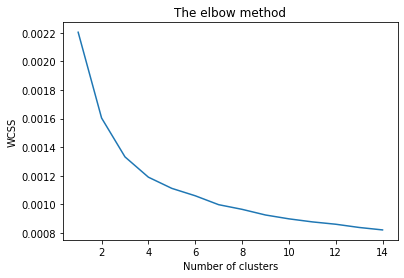

In [21]:
plot_kmeans_wcss(kmeans_wcss, 15)

## Plot results

In [22]:
def get_kmeans_results(y_pred):
    # Frequency count of the Output clusters
    unique, counts = np.unique(y_pred, return_counts=True)
    print('K Means Output Cluster Frequency')
    print(dict(zip(unique, counts)))
    return unique, counts

def get_dba_results(y_pred):
    # Frequency count of the Output clusters
    unique, counts = np.unique(y_pred, return_counts=True)
    print('K Means DTW Output Cluster Frequency')
    print(dict(zip(unique, counts)))
    return unique, counts

In [23]:
def plot_kmeans_clusters(X_train, n_clusters, km, y_pred, sz, n_samples = 25):
    plt.figure(figsize=(15, 15))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, n_clusters, yi + 1)
        for xx in X_train[y_pred == yi][:n_samples]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(0.1, 0.2)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                transform=plt.gca().transAxes)
        
        if yi == 1:
            plt.title(f"Euclidean $k$-means with {n_samples} samples under each cluster")
def plot_dba_clusters(X_train, n_clusters, dba_km, y_pred, sz, n_samples = 25):
    plt.figure(figsize=(15, 15))
    for yi in range(n_clusters):
        plt.subplot(n_clusters, n_clusters, yi + 1)
        for xx in X_train[y_pred == yi][:n_samples]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(0.1, 0.2)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                transform=plt.gca().transAxes)
        
        if yi == 1:
            plt.title(f"DBA $k$-means with {n_samples} samples under each cluster")

In [24]:
km_path = 'model_km'
km_dict = train_kmeans(X_train, 6, 1, km_path, seed=0)

Euclidean k-means
0.002 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 0.001 --> 
y_pred.shape (24291,)


In [36]:
km_dict['km']

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=50,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=6, n_init=1, n_jobs=None,
                 random_state=0, tol=1e-06, verbose=True)

In [25]:
kmeans_unique, kmeans_counts = get_kmeans_results(km_dict['y_pred'])


K Means Output Cluster Frequency
{0: 6529, 1: 8670, 2: 747, 3: 5063, 4: 356, 5: 2926}


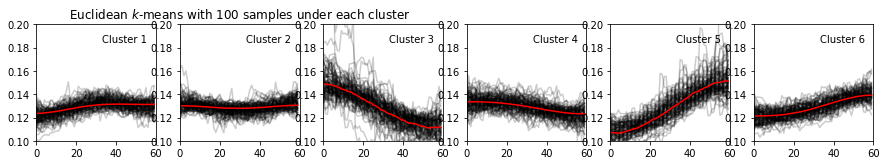

In [26]:
# 100 samples under each cluster
plot_kmeans_clusters(X_train, 6, km_dict['km'], km_dict['y_pred'], X_train.shape[1], 100)

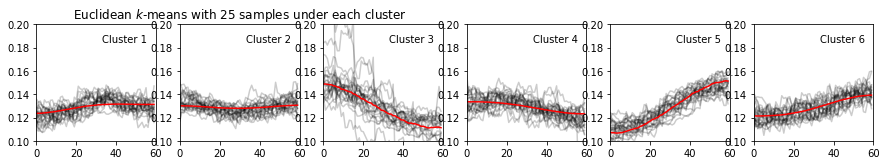

In [27]:
# 25 samples under each cluster
plot_kmeans_clusters(X_train, 6, km_dict['km'], km_dict['y_pred'], X_train.shape[1])

## Optimal clusters for KMeans with DTW

In [ ]:
# dba_wcss = get_dba_optimal_clusters(16)

In [ ]:
# plot_dba_wcss(dba_wcss, 16)

## Train models on euclidean and dtw


In [28]:
def train_dba(X_train, n_clusters, trial, dba_path, seed=0):
    dba_dict = {}
    if not os.path.exists(dba_path):
        # https://appdividend.com/2021/07/03/how-to-create-directory-if-not-exist-in-python/
        # Create a new directory
        os.makedirs(dba_path)
        print(f"{dba_path} directory is created")
    # Euclidean k-means
    print("DBA k-means")
    dba_km = TimeSeriesKMeans(n_clusters,
                              n_init=1,
                              max_iter = 10,
                              metric="dtw",
                              verbose=True,
                              dtw_inertia = True,
                              max_iter_barycenter=10,
                              random_state=seed)
    dba_km.fit(X_train)
    dba_km.to_pickle(f"{dba_path}/trial-{trial}-dba-km.pkl")
    y_pred = dba_km.predict(X_train)
    print(f"y_pred.shape {y_pred.shape}")
    dba_dict['dba_km'] = dba_km
    dba_dict['y_pred'] = y_pred
    return dba_dict

In [29]:
dba_path = 'model_dba'
dba_dict = train_dba(X_train, 6, 1, dba_path, seed=0)

model_dba directory is created
DBA k-means


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 24291 out of 24291 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 72873 out of 72873 | elapsed:   13.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 72873 out of 72873 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 72873 out of 72873 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 72873 out of 72873 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 72873 out of 72873 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurren

0.001 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145746 out of 145746 | elapsed:   27.9s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145746 out of 145746 | elapsed:   27.9s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145746 out of 145746 | elapsed:   27.9s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145746 out of 145746 | elapsed:   27.9s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145746 out of 145746 | elapsed:   28.0s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145746 out of 145746 | elapsed:   27.9s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145746 out of 145746 | elapsed:   28.0s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145746 out of 145746 | elapsed:   28.0s finished


0.000 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145746 out of 145746 | elapsed:   27.9s finished


0.000 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145746 out of 145746 | elapsed:   28.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


y_pred.shape (24291,)


[Parallel(n_jobs=1)]: Done 145746 out of 145746 | elapsed:   27.9s finished


In [30]:
dba_unique, dba_counts = get_dba_results(dba_dict['y_pred'])


K Means DTW Output Cluster Frequency
{0: 4558, 1: 5664, 2: 11756, 3: 1437, 4: 307, 5: 569}


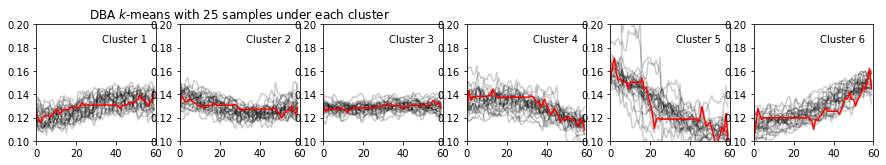

In [32]:
plot_dba_clusters(X_train, 6, dba_dict['dba_km'], dba_dict['y_pred'], X_train.shape[1], n_samples = 25)

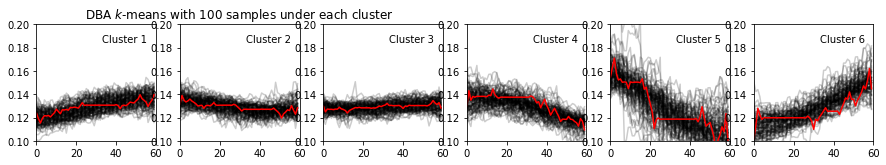

In [33]:
plot_dba_clusters(X_train, 6, dba_dict['dba_km'], dba_dict['y_pred'], X_train.shape[1], 100)

## [tslearn similarity metrics like dtw_score correlation matrix](https://tslearn.readthedocs.io/en/stable/gen_modules/tslearn.metrics.html)


In [35]:
dba_dict['dba_km']

TimeSeriesKMeans(dtw_inertia=True, init='k-means++', max_iter=10,
                 max_iter_barycenter=10, metric='dtw', metric_params=None,
                 n_clusters=6, n_init=1, n_jobs=None, random_state=0, tol=1e-06,
                 verbose=True)

In [ ]:
dba_dict['dba_km'].in

In [38]:
X_train.shape

(24291, 60, 1)

## [Get samples under each cluster](https://stackoverflow.com/questions/36195457/how-to-get-the-samples-in-each-cluster)

In [ ]:
def get_samples_per_cluster():
    import pandas as pd
    cluster_map = pd.DataFrame()
    

In [ ]:
def get_cdist_dtw():
    

## Given clusters, how many time series samples belong to any of the companies? 


## Clustering plots, once you get clusters